## 2. ResNet

In [4]:
import os

import torch
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load, Transform and Visualize Data

#### Load

In [5]:
# Define training, test and validation data
data_dir = '/Users/Shazzad Hasan/Deep_Learning/datasets/cats_and_dogs_small'
train_dir = os.path.join(data_dir, 'train/')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# classes are folders in each directories with the following list of names
classes = ['cats', 'dogs']

#### Transform

In [10]:
# ResNet-34 takes 224 by 224 images as inputs
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
validation_data = datasets.ImageFolder(validation_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Number of training images:', len(train_data))
print('Number of validation images:', len(validation_data))
print('Number of test images:', len(test_data))

Number of training images: 2000
Number of validation images: 1000
Number of test images: 1000


#### Visualize

In [13]:
# define dataloader parameters
batch_size = 20
num_workers = 0

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

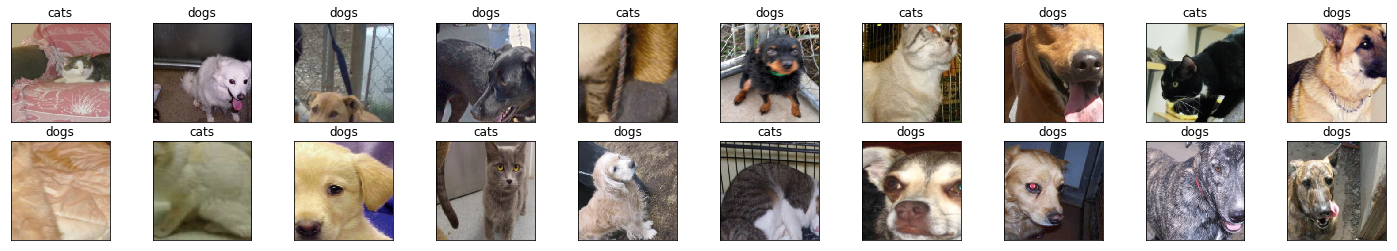

In [14]:
# visualize a batch of sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy 
images = images.numpy()
# plot the images along with corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(classes[labels[idx]])

### Define the Model

In [20]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available! Training on GPU')

CUDA is not available. Training on CPU


In [15]:
# load the pretrained model form pytorch
resnet34 = models.resnet34(pretrained=True)
# print our the model structure
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
print(resnet34.fc.in_features)
print(resnet34.fc.out_features)

512
1000


In [18]:
# Freeze training for all 'features' layers
for param in resnet34.parameters():
    param.requires_grad = False

### Final classifier layer

In [22]:
import torch.nn as nn

n_inputs = resnet34.fc.in_features
# add last linear layer. [new layer will automatically have required_grad=True]
last_layer = nn.Linear(n_inputs, len(classes))
resnet34.fc = last_layer

if train_on_gpu:
    resnet34.cuda()
    
# check to see that the last layer produces the expected number of outputs
print(resnet34.fc.out_features)

2


### Specify Loss Function and Optimizer

In [23]:
import torch.optim as optim

# specify loss function 
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(resnet34.fc.parameters(), lr=0.001)

### Training

In [26]:
# number of epochs to train the model
n_epochs = 1

for epoch in range(1, n_epochs+1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    
    #################
    # train the model
    #################
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensor to GPU is CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all the optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted output by passing inputs to the model
        output = resnet34(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # parameter update: perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

C:\Users\Shazzad Hasan\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Shazzad Hasan\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Shazzad Hasan\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Shazzad Hasan\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Shazzad Hasan\Anaconda3\lib\site-packages\PIL\TiffImagePlu

Epoch 1, Batch 20 loss: 0.4315310016274452
Epoch 1, Batch 40 loss: 0.3932239755988121
Epoch 1, Batch 60 loss: 0.3571852177381515
Epoch 1, Batch 80 loss: 0.3343550935387611
Epoch 1, Batch 100 loss: 0.3431277059018612


In [29]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

resnet34.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet34(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.281899

Test Accuracy of  cats: 94% (471/500)
Test Accuracy of  dogs: 91% (456/500)

Test Accuracy (Overall): 92% (927/1000)


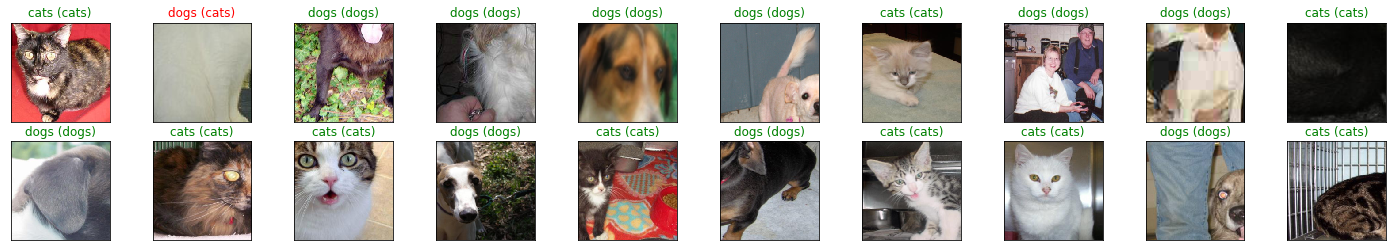

In [31]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = resnet34(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))